# Imports and configurations

In [1]:
import numpy as np
import pandas as pd
import torch
import scipy
from torch.utils.data import TensorDataset as TData
from torch.utils.data import DataLoader as DL
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
device

'cuda'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = pd.read_csv("/content/drive/MyDrive/Longhorn Neurotech/BCICIV_2a_all_patients.csv") # loading in the csv dataset with pandas

# Exploratory Data Analysis and Preprocessing

In [5]:
binary_mi = dataset.loc[(dataset['label'] == 'left') | (dataset['label'] == 'right')]
binary_mi.label.unique() # check that our row filter worked

array(['right', 'left'], dtype=object)

In [7]:
t0 = binary_mi.time.iloc[:-1]
t1 = binary_mi.time.iloc[1:]
t0.reset_index(drop=True, inplace=True)
t1.reset_index(drop=True, inplace=True)

const_diff = ((t0 - t1 < -0.0039) & (t0 - t1 > -0.0041))
const_diff[const_diff != True]

,time
200,False
401,False
602,False
803,False
1004,False
...,...
259490,False
259691,False
259892,False
260093,False


In [8]:
binary_mi.iloc[200:, 2] # time discrepancy seems to be caused by label change

,label
602,right
603,left
604,left
605,left
606,left
...,...
491842,right
491843,right
491844,right
491845,right


In [9]:
# don't care about time and epoch anymore
pruned_mi = binary_mi.drop(columns = ['time', 'epoch'])
pruned_mi.head()

,patient,label,EEG-Fz,EEG-0,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5,EEG-C3,...,EEG-8,EEG-9,EEG-10,EEG-11,EEG-12,EEG-13,EEG-14,EEG-Pz,EEG-15,EEG-16
402,1,right,-7.253367,-7.846816,-6.412021,-3.084196,0.023902,1.723496,-4.727450,-4.680500,...,3.113220,-0.901954,1.939467,2.611793,3.706669,3.466285,0.878394,2.311312,2.688791,2.039001
403,1,right,-5.988274,-7.314146,-3.828569,-3.821057,0.312432,-0.771177,-2.241655,-3.757205,...,3.987687,-0.027487,3.302215,1.923760,2.139730,2.143486,1.215752,1.867420,2.293727,1.497453
404,1,right,-5.113807,-3.558819,-2.026367,-3.874324,-1.010367,-2.435772,1.904297,-0.587816,...,4.032076,2.311824,3.004808,-0.277945,0.523963,-0.155874,1.504282,1.716496,0.873272,2.274264
405,1,right,-4.805302,-1.199533,-1.473722,-3.516991,-1.873737,-2.078439,3.970614,2.943346,...,1.069097,3.645720,3.508625,0.274701,-1.169485,-2.972369,2.935834,1.146095,0.058730,2.533941
406,1,right,-4.308143,-0.604718,-0.585937,-3.654597,-2.353140,-4.169171,6.372070,4.417067,...,-1.754056,4.826472,5.031175,-0.155874,-1.648888,-4.672476,3.530649,2.278020,-0.274189,1.468600


In [10]:
# get unique patients and labels
patients = binary_mi.patient.unique() # 1-9
labels = binary_mi.label.unique()     # left and right

In [11]:
left_hand = []
right_hand = []

# for each patient, get patient readings, convert to numpy array, and add
# to list corresponding to target (left or right)
for patient in patients:
  left_df = pruned_mi[(pruned_mi['patient'] == patient) & (pruned_mi['label'] == 'left')]
  right_df = pruned_mi[(pruned_mi['patient'] == patient) & (pruned_mi['label'] == 'right')]

  left_hand.append(left_df.iloc[:, 2:].to_numpy().T)
  right_hand.append(right_df.iloc[:, 2:].to_numpy().T)

right_hand[0].shape # shows shape of each list element

(22, 14472)

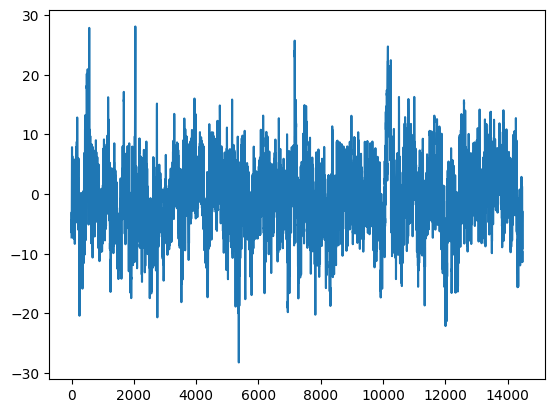

In [12]:
plt.plot(right_hand[0][0]) # visualizing first channel of first patient thinking of right hand motion

In [13]:
# get sequence length/length of each signal
left_len = left_hand[0].shape[1]
right_len = right_hand[0].shape[1]
# portion of sequence used for validation/testing set
left_eval_len = int(0.4 * left_hand[0].shape[1])
right_eval_len = int(0.4 * right_hand[0].shape[1])

# select random starting indexes for sub-sequences for validation and testing sets
left_hand_partition = np.random.randint(0, left_len - left_eval_len, len(left_hand))
right_hand_partition = np.random.randint(0, right_len - right_eval_len, len(right_hand))

# initialize lists to hold respective signals
left_train = []
left_val = []
left_test = []
right_train = []
right_val = []
right_test = []

# create training, validation, and testing sets for left hand signals
for i, num in enumerate(left_hand_partition):
  # get ending index of subsequence being cropped for validation and testing sets
  upper_end = num + left_eval_len
  # add portion of sequence excluding num:upper_end (portion used for evaluation)
  left_train.append(left_hand[i][:, list(range(num)) + list(range(upper_end, left_len))])
  # first half of subsequence used for validation
  left_val.append(left_hand[i][:, num:num+(left_eval_len//2)])
  # second half used for test set
  left_test.append(left_hand[i][:, num+(left_eval_len//2):num + left_eval_len])

# create training, validation, and testing sets for right hand signals
for i, num in enumerate(right_hand_partition):
  # get ending index of subsequence being cropped for validation and testing sets
  upper_end = num + right_eval_len
  # add portion of sequence excluding num:upper_end (portion used for evaluation)
  right_train.append(right_hand[i][:, list(range(num)) + list(range(upper_end, right_len))])
  # first half of subsequence used for validation
  right_val.append(right_hand[i][:, num:num+(right_eval_len//2)])
  # second half used for test set
  right_test.append(right_hand[i][:, num+(right_eval_len//2):num + right_eval_len])

# Signal Preprocessing

In [14]:
!pip install EMD-signal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.0 MB/s eta 0:00:00


In [15]:
# function to bandpass filter signals
def bandpass_filter(signal, crit_freq = [5, 40], sampling_freq = 125):
  order = 4
  b, a = scipy.signal.butter(order, crit_freq, btype = 'bandpass', fs = sampling_freq)
  processed_signal = scipy.signal.filtfilt(b, a, signal, 1)
  return processed_signal

# segment a signal using sliding window technique, specifying sample frequency, window size, and window shift
def segmentation(signal, sampling_freq=125, window_size=1, window_shift=0.016):
  w_size = int(sampling_freq * window_size)
  w_shift = int(sampling_freq * window_shift)
  segments = []
  i = 0
  while i + w_size <= signal.shape[1]:
    segments.append(signal[:, i: i + w_size])
    i += w_shift
  return segments

# apply preprocessing steps in sequence to each signal
def preprocess(signals, crit_freq=[5,35], fs=250):
  preprocessed = []
  for signal in signals:
    # perform bandpass filter on each signal
    filtered_signal = bandpass_filter(signal, crit_freq, fs)
    # channel-wise z-score normalization
    normed_signal = (filtered_signal - filtered_signal.mean(1, keepdims=True)) / filtered_signal.std(1, keepdims=True)
    # segmentation of signals
    segments = segmentation(normed_signal, fs)
    # add signals to list
    preprocessed.extend(segments)
  return preprocessed

In [16]:
from PyEMD import EMD  # Import EMD class from PyEMD

def apply_emd_preprocessing(signals, crit_freq=[5, 35], fs=250, n_imfs_to_keep=5):
    """Converts (22, XX) samples → (110, XX) by stacking IMFs as channels."""
    preprocessed_emd_signals = []
    emd = EMD()

    for signal in signals:  # signal shape: (22, XX)
        all_imfs = []

        # Process each channel
        for channel_idx in range(signal.shape[0]):
            channel_signal = signal[channel_idx, :]
            t = np.arange(len(channel_signal)) / fs
            imfs = emd(channel_signal, t)[:n_imfs_to_keep]  # Get 5 IMFs

            # Stack IMFs vertically: (5, XX) → becomes 5 new channels
            all_imfs.append(imfs)  # List of (5, XX) arrays

        # Combine across channels: (22 channels × 5 IMFs) = 110 channels
        stacked_imfs = np.vstack(all_imfs)  # Shape: (110, XX)
        preprocessed_emd_signals.append(stacked_imfs)

    return preprocessed_emd_signals  # List of (110, XX) arrays

In [17]:
# train_left = apply_emd_preprocessing(left_train)
# val_left = apply_emd_preprocessing(left_val)
# test_left = apply_emd_preprocessing(left_test)

# train_right = apply_emd_preprocessing(right_train)
# val_right = apply_emd_preprocessing(right_val)
# test_right = apply_emd_preprocessing(right_test)

# generate preprocessed segments for training, validation, and testing
train_left = preprocess(left_train)
val_left = preprocess(left_val)
test_left = preprocess(left_test)
train_right = preprocess(right_train)
val_right = preprocess(right_val)
test_right = preprocess(right_test)

# print number of samples corresponding to left and right hand targets
print(f'left samples: {len(train_left) + len(val_left) + len(test_left)}, right samples: {len(train_right) + len(val_right) + len(test_right)}')
# print shape of each sample
print(f'segment shape: {train_left[0].shape}')

left samples: 30897, right samples: 30897
segment shape: (22, 250)


In [17]:
def emd_segmentation(signal, sampling_freq=250, window_size=1, window_shift=0.01):
    """Splits (110, XX) → List of (110, window_samples)."""
    window_samples = int(sampling_freq * window_size)
    shift_samples = int(sampling_freq * window_shift)

    segments = []
    i = 0
    while i + window_samples <= signal.shape[1]:
        segments.append(signal[:, i:i+window_samples])  # Keep channel dimension
        i += shift_samples
    return segments

In [18]:
# train_left_processed = [seg for signal in train_left for seg in emd_segmentation(signal)]
# val_left_processed = [seg for signal in val_left for seg in emd_segmentation(signal)]
# test_left_processed = [seg for signal in test_left for seg in emd_segmentation(signal)]

# train_right_processed = [seg for signal in train_right for seg in emd_segmentation(signal)]
# val_right_processed = [seg for signal in val_right for seg in emd_segmentation(signal)]
# test_right_processed = [seg for signal in test_right for seg in emd_segmentation(signal)]

train_left_processed = train_left
val_left_processed = val_left
test_left_processed = test_left
train_right_processed = train_right
val_right_processed = val_right
test_right_processed = test_right

In [19]:
np.array(train_left_processed).shape

(18981, 22, 250)

# Partitioning Dataset and Creating Data Loaders

In [20]:
# combine left and right signals to generate signal training, validation, and testing set
train_eeg = train_left_processed + train_right_processed
val_eeg = val_left_processed + val_right_processed
test_eeg = test_left_processed + test_right_processed
train_labels = [0 for i in range(len(train_left_processed))] + [1 for i in range(len(train_right_processed))]
val_labels = [0 for i in range(len(val_left_processed))] + [1 for i in range(len(val_right_processed))]
test_labels = [0 for i in range(len(test_left_processed))] + [1 for i in range(len(test_right_processed))]

In [21]:
# create torch tensor of zeros to hold data
train_eeg_tensor = torch.zeros((len(train_eeg), train_eeg[0].shape[0], train_eeg[0].shape[1]))
valid_eeg_tensor = torch.zeros((len(val_eeg), val_eeg[0].shape[0], val_eeg[0].shape[1]))
test_eeg_tensor = torch.zeros((len(test_eeg), test_eeg[0].shape[0], test_eeg[0].shape[1]))

# add each sample in train, validation, and test lists to appropriate tensor at correct index
for i in range(len(train_eeg)):
  tens = torch.from_numpy(train_eeg[i].copy())
  train_eeg_tensor[i] = tens
for i in range(len(val_eeg)):
  tens = torch.from_numpy(val_eeg[i].copy())
  valid_eeg_tensor[i] = tens
for i in range(len(test_eeg)):
  tens = torch.from_numpy(test_eeg[i].copy())
  test_eeg_tensor[i] = tens

# create zero tensor for one hot encoded labels
train_label_tensor = torch.zeros(len(train_labels), 2)
valid_label_tensor = torch.zeros(len(val_labels), 2)
test_label_tensor = torch.zeros(len(test_labels), 2)

# add labels to tensor at correct index
for i in range(len(train_labels)):
  label = train_labels[i]
  train_label_tensor[i][label] = 1
for i in range(len(val_labels)):
  label = val_labels[i]
  valid_label_tensor[i][label] = 1
for i in range(len(test_labels)):
  label = test_labels[i]
  test_label_tensor[i][label] = 1

# convert input, target tensors to Tensor Dataset from torch
train_ds = TData(train_eeg_tensor, train_label_tensor)
valid_ds = TData(valid_eeg_tensor, valid_label_tensor)
test_ds = TData(test_eeg_tensor, test_label_tensor)
# create dataloaders to hold batched data (batch size chosen was 64)
train_dl = DL(train_ds, batch_size=64, shuffle= True, drop_last = True)
valid_dl = DL(valid_ds, batch_size=64, shuffle= True, drop_last = True)
test_dl = DL(test_ds, batch_size=64, shuffle = True, drop_last = True)

In [23]:
del train_eeg, val_eeg, test_eeg, train_labels, val_labels, test_labels

NameError: name 'train_eeg' is not defined

# Separable-Conv Model

In [37]:
import torch
import torch.nn as nn

class EMD_PCNN(nn.Module):
    def __init__(self, input_channels=22, num_classes=2, input_length=250):
        super().__init__()


        self.branch1 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=20, padding='same'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2),


            # nn.Conv1d(16, 32, kernel_size=10, padding='same'),
            # nn.BatchNorm1d(32),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            # nn.MaxPool1d(2)
        )


        self.branch2 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=10, padding='same'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2),


            # nn.Conv1d(16, 32, kernel_size=5, padding='same'),
            # nn.BatchNorm1d(32),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            # nn.MaxPool1d(2)
        )


        with torch.no_grad():
            example_input = torch.randn(1, input_channels, input_length)
            out1 = self.branch1(example_input)
            out2 = self.branch2(example_input)
            self.fc_input_dim = out1.numel() + out2.numel()

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        combined = torch.cat([out1.flatten(1), out2.flatten(1)], dim=1)
        return self.fc(combined)

In [59]:
import torch
import torch.nn as nn

class PCNN_3Branch(nn.Module):
    def __init__(self, input_channels=22, num_classes=2, input_length=250):
        super().__init__()


        self.branch1 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=20, padding='same'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2),
        )


        self.branch2 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=10, padding='same'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2),
        )

        self.branch3 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=5, padding='same'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2),
        )

        self.branch4 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=5, padding='same'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2),
        )


        with torch.no_grad():
            example_input = torch.randn(1, input_channels, input_length)
            out1 = self.branch1(example_input)
            out2 = self.branch2(example_input)
            out3 = self.branch3(example_input)
            out4 = self.branch4(example_input)
            self.fc_input_dim = out1.numel() + out2.numel() + out3.numel() + out4.numel()

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out4 = self.branch4(x)
        combined = torch.cat([out1.flatten(1), out2.flatten(1), out3.flatten(1), out4.flatten(1)], dim=1)
        return self.fc(combined)

In [24]:
del model

# Model training

In [60]:
from tqdm.auto import tqdm
epochs = 10

# model = EMD_PCNN().to(device)
model = PCNN_3Branch().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0009, momentum = 0.9, weight_decay=5e-3)

In [61]:
train_losses = []
val_losses = []
accs = []
max_acc = 0
for i in range(epochs):
  total_train_loss = 0.0
  # set model to training mode
  model.train()
  # create progress bar
  pbar = tqdm(total=len(train_dl))
  for j, (sig, labels) in tqdm(enumerate(train_dl)):
    # add signal and label to cuda device
    sig = sig.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    # forward pass
    pred = model(sig)
    # loss evaluation
    loss = criterion(pred, labels)
    # backpropagation
    loss.backward()
    optimizer.step()

    total_train_loss += loss.item()
    # update progress bar with running loss
    pbar.set_description(f"Epoch {i + 1}    loss={total_train_loss / (j + 1):0.4f}")
    pbar.update(1)
  pbar.close()
  train_losses.append(total_train_loss / len(train_dl))

  total_val_loss = 0.0
  total_accuracy = 0.0
  # set model to evaluation mode, which changes the behavior
  # of some layers like dropout and batch normalization
  model.eval()
  with torch.no_grad():
      # create progress bar
      pbar = tqdm(total=len(valid_dl))
      for j, (sig, labels) in enumerate(valid_dl):
          # send signal and label to cuda device
          sig = sig.to(device)
          labels = labels.to(device)
          # make prediction and evaluate loss
          pred = model(sig)
          loss = criterion(pred, labels)

          # perform softmax on output which is usually performed by loss automatically
          # this gives a probability vector
          prob_pred = torch.nn.functional.softmax(pred, -1)
          # compute accuracies by
          # 1. getting index of highest number (highest probability prediction)
          # 2. comparing the tensors element wise which gives boolean array comparing predictions to ground truth
          # 3. converting boolean array into array of 0s and 1s
          # 4. calculating mean with binary array, which gives (correct predictions) / (total predictions)
          acc = (prob_pred.argmax(-1) == labels.argmax(-1)).float().mean()
          total_val_loss += loss.item()
          total_accuracy += acc.item()

          # update progress bar with val loss and accuracy
          pbar.set_description(f"val loss={total_val_loss / (j + 1):.4f}    val acc={total_accuracy / (j + 1):.4f}")
          pbar.update(1)
      print()
      pbar.close()
      val_losses.append(total_val_loss / len(valid_dl))
      accs.append(total_accuracy / len(valid_dl))

  # save model if accuracy is best seen
  if accs[-1] > max_acc:
    # dictionary with model state dict, optimizer state dict, and best accuracy
    checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'best_acc': accs[-1]}
    # save dictionary to specified file path if it exists or create new one otherwise
    torch.save(checkpoint, 'model.pth.tar')
    print('Model Saved')
    max_acc = accs[-1]

  0%|          | 0/593 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]


Model Saved


  0%|          | 0/593 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]


Model Saved


  0%|          | 0/593 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]


Model Saved


  0%|          | 0/593 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/593 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]


Model Saved


  0%|          | 0/593 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]


Model Saved


  0%|          | 0/593 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/593 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]


Model Saved


  0%|          | 0/593 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/593 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

# Model evaluation

In [67]:
# loading most accurate model
ckpt_dict = torch.load('model.pth.tar', weights_only=True)
model.load_state_dict(ckpt_dict['state_dict'])
# setting model to evaluation mode
model.eval()
test_accuracy = 0.0
test_loss = 0.0
with torch.no_grad():
      for signal, labels in test_dl:
          # send signal and label to cuda device
          signal = signal.to(device)
          labels = labels.to(device)
          # make prediction and evaluate loss
          pred = model(signal)
          loss = criterion(pred, labels)
          # compute probability vector and accuracy
          prob_pred = torch.nn.functional.softmax(pred, -1)
          acc = (prob_pred.argmax(-1) == labels.argmax(-1)).float().mean()
          test_loss += loss.item()
          test_accuracy += acc.item()

# display test set loss and accuracy
print(f'Test set    loss: {test_loss / len(test_dl):.4f}    accuracy: {test_accuracy / len(test_dl):.4f}')

Test set    loss: 0.6030    accuracy: 0.7597


In [75]:
sig, labels = next(iter(test_dl))
sig = sig.to(device)
labels = labels.to(device)

with torch.no_grad():
    pred = model(sig)
    prob_pred = torch.nn.functional.softmax(pred, -1)
    predicted_labels = prob_pred.argmax(-1)

print(labels[:20].argmax(-1).cpu().numpy())
print(predicted_labels[:20].cpu().numpy())

[1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0]
[1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 0]


Text(0, 0.5, 'cross entropy loss')

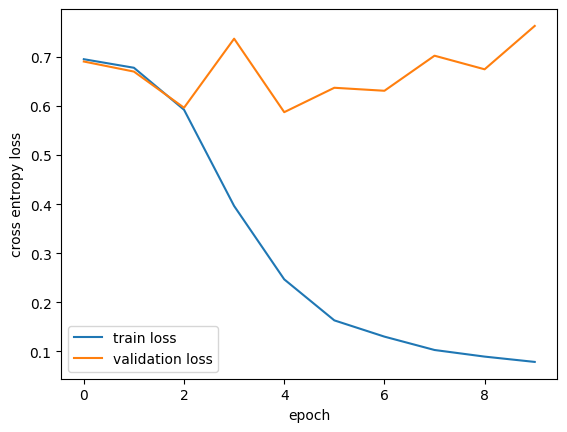

In [63]:
# plotting train and validation loss
plt.plot(train_losses, label = 'train loss')
plt.plot(val_losses, label = 'validation loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')

Text(0, 0.5, 'accuracy')

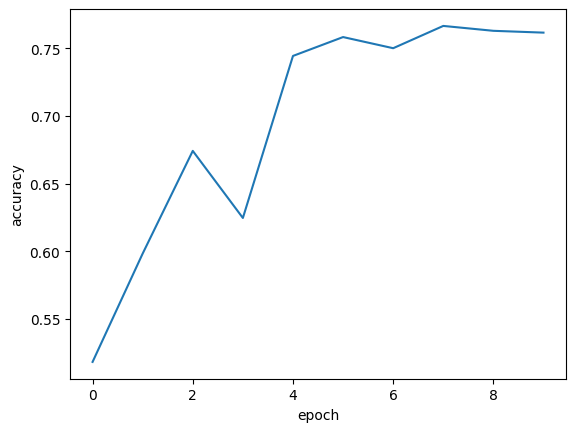

In [64]:
# plotting validation accuracy
plt.plot(accs)
plt.xlabel('epoch')
plt.ylabel('accuracy')